# Prestige Bias model

In [330]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from numba import jit
from scipy import interpolate
from scipy import optimize
from scipy import special
from scipy import signal
import random
import scipy.stats as st
import gc
from scipy.integrate import quad 
from scipy import optimize

In [331]:
N = 10000 # generation size
A = np.random.normal(0, 1, size=N)
A.shape

(10000,)

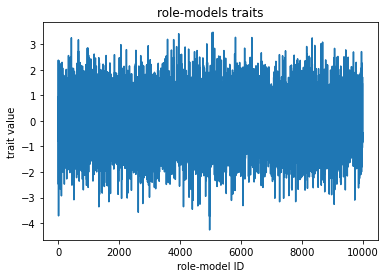

In [332]:
plt.plot(A,label='indicator')
plt.xlabel('role-model ID')
plt.ylabel('trait value')
plt.title('role-models traits')
plt.show()

In [372]:
b,J = 1,1
A_hat = 1
alpha = 0.5

print(f'b={b}\tJ={J}\tA_hat={A_hat}\t alpha={alpha:.2f}')

b=1	J=1	A_hat=1	 alpha=0.50


In [334]:
def bias(traits,b=b,J=J,A_hat=A_hat):
    return b * np.exp(-(((A_hat - traits) ** 2) / (2*J)))

def probability_err(p,n):
    return 2*1.96*np.sqrt((p*(1-p))/n)

def influence_bias(traits,b,J,success_correlated=True):
    inf_bias = bias(traits,b,J)
    return inf_bias if success_correlated else (1-inf_bias)
    
def is_converging(mean,var,conv_val=A_hat,mean_tol=0.01,var_tol=0.007):
    return np.abs(mean-conv_val) <= mean_tol and var <= var_tol

def mean_distance_from_opt(arr,opt=A_hat):
    return ((arr-opt)**2).mean()

def get_convergence_index(arr,n=5):
    count = 0
    for index,val in enumerate(arr):
        if val:
            count += 1
        else:
            count = 0
        if count == n:
            return index-n   
    

def plot_model(data):
    fig, ax = plt.subplots()
    binary = len(data.shape)==1

    if binary:
        data = data[~np.isnan(data)]
        
        window = min(len(data),51)
        window = window - 1 if window%2 == 0 else window
        
        smoothed_data = signal.savgol_filter(data,window,5)
        
        ax.plot(range(len(data)),smoothed_data,label='indicator freq')
    else:
        ax.plot((0,len(data.shape[1])),(A_hat,A_hat),label='A_hat',linestyle='--')

## Influence advantage

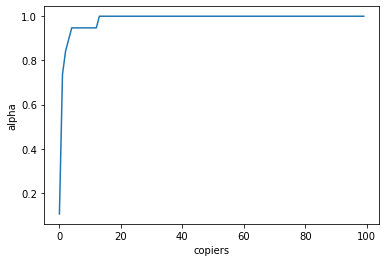

In [433]:
def find_opt(alpha, traits, K):
    alpha=alpha[0]
    if alpha < 0 or alpha > 1:
        return -np.inf
    prestige = traits*alpha + (1-alpha)*K
    prestige /= prestige.sum()
    val = np.average(traits, weights = prestige)
    res = (A_hat-val)**2
    return res


def choose_influence(A_,eta):
    e = np.random.normal(0, scale = eta, size=len(A_))
    K = np.zeros(len(A_))
    alphas = []
    outs = []
    for i in range(len(A_)):
        biased_A = bias(A_,b,J,A_hat)+e[i]

        alpha,out,*_ = optimize.brute(find_opt,[(0.00001,1)],args=(biased_A,K),disp=False,full_output=True,
                                     finish=None)
        alphas.append(alpha)
        outs.append(out)
        prestige = A_*alpha + (1-alpha)*K
        prestige /= prestige.sum()
        K += prestige
        
    return alphas,outs

A_ = np.random.normal(0,1, size=100)
alphas,outs = choose_influence(A_,0.1)
plt.xlabel('copiers')
plt.ylabel('alpha')
plt.plot(range(len(alphas)),alphas);
plt.savefig('../figures/choose_alpha_100.pdf')
# plt.plot(range(len(alphas)),outs);

## Numeric validation

In [336]:
def single_DM_generation(A_,alpha,mutation=None):
    alpha_tag = alpha/(1-alpha)
    if mutation:
        A_ += np.random.normal(0, scale = mutation, size=len(A_))
    prestige = bias(A_,b,J,A_hat)*alpha_tag
    dist = np.random.dirichlet(prestige)
    K = np.random.multinomial(len(A_),dist)
    return K


def single_GT_generation(A_,alpha,mutation=None):
    if mutation:
        A_ += np.random.normal(0, scale = mutation, size=len(A_))
    biased_A = bias(A_,b,J,A_hat)*alpha
    K = np.zeros(len(A_))
    for _ in range(len(A_)):
        prestige = biased_A + (1-alpha)*K
        prestige /= prestige.sum()
        chosen_role_model = np.searchsorted(prestige.cumsum(),np.random.rand())
        K[chosen_role_model] += 1
    
    return K
    
    
def get_bias(A_,alpha=None):
    if alpha:
        alpha_tag = alpha/(1-alpha)
        biased = bias(A_,b,J,A_hat)*alpha_tag
    else:
        biased = bias(A_,b,J,A_hat)
        
    return biased/biased.sum()
    
    
def get_expected(A_,alpha):
    alpha_tag = alpha/(1-alpha)
    prestige = bias(A_,b,J,A_hat)*alpha_tag
    prestige /= prestige.sum()
    K = len(A_)*prestige
    return K


def chi_squared_p_val(o,e):
    return stats.chisquare(o,e)[1]

In [337]:
p_vals = []
dists = []
A_ = np.random.normal(0,1, size=2000)
alpha = 0.1
mutation = 0
E = get_expected(A_.copy(),alpha)
m = 1000
for i in range(m):
    o_GT = single_GT_generation(A_.copy(),alpha,mutation)
    dists.append(o_GT)
    _,p_val = stats.chisquare(o_GT,E)
    p_vals.append(p_val)
    
dists_avg = np.array(dists).mean(axis=0)

### DM

In [338]:
p_val = chi_squared_p_val(dists_avg,E)
print(f'the p value of the average distribution of {m} simulations is: {p_val}')

the p value of the average distribution of 1000 simulations is: 1.0


### GBD

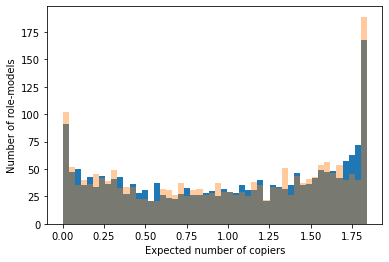

In [339]:
mod_dists = dists_avg.copy()
mod_dists[mod_dists>E.max()]=E.max()

plt.xlabel('Expected number of copiers')
plt.ylabel('Number of role-models')
plt.hist(E,bins=50)
plt.hist(mod_dists,bins=50,alpha=0.4)
plt.savefig('../figures/GBD_validation.pdf')

### Validations

In [340]:
p_val = chi_squared_p_val(np.ones(len(A_)),E)
print(f'the p value of the expected uniform distribution is: {p_val}')

the p value of the expected uniform distribution is: 0.0


In [341]:
rv = stats.multinomial(len(A_),get_bias(A_,alpha))
p_val = chi_squared_p_val(dists[87],E)
print(f'the p value of the expected multinomial distribution is: {p_val}')

the p value of the expected multinomial distribution is: 0.0


## Dirichlet Approximation Model

In [342]:
@jit(nopython=True)
def make_array_from_copiers(K,original):
    new_arr = np.zeros(len(K))
    i=0
    for index,copiers in enumerate(K):
        for _ in range(int(copiers)):
            new_arr[i]= original[index]
            i= i+ 1
    return new_arr

In [343]:
def prestige_dirichlet(A_,m=1000,binary=False,mutation_scale=0,
                       b=b,J=J,alpha=0.5,A_hat=A_hat,conv_tol=0,k=None,l=None):
    B_hat = A_[A_!=A_hat][0]
    np.random.seed()
    if binary:
        p = np.empty(m)
    else:    
        p = np.empty((2,m))
    p[:] = np.nan
    
    i=0
    while True:
        if binary and not np.isnan(p[-1]):
            addition = np.empty(m)
            addition[:] = np.nan
            p = np.array(list(p)+ list(addition))
        if binary:
            p[i]=len(A_[A_==A_hat])/len(A_)
        else:
            p[0,i]=A_.mean()
            p[1,i]=A_.var()
        
        A_converge = (np.abs(A_-A_[0]) <= conv_tol).all()
        if A_converge:
            break
        
        if mutation_scale > 0 and not binary:
            A_ += np.random.normal(0, scale = mutation_scale, size=len(A_))
        
        alpha_tag = alpha/(1-alpha)
        if k and i%(k+l)>k:
            prestige = bias(A_,b,J,B_hat)*alpha_tag
        else:
            prestige = bias(A_,b,J,A_hat)*alpha_tag
        
        dist = np.random.dirichlet(prestige)
        K = np.random.multinomial(len(A_),dist)
        A_ = make_array_from_copiers(K,A_)
        i += 1
    
    return p

### Test binary model

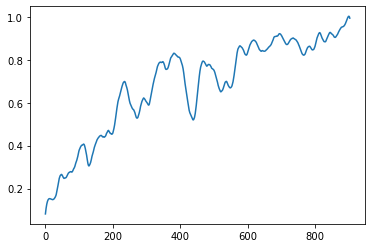

In [344]:
A_ = np.zeros(1000)
A_[:100] = A_hat
A_[A_==0] = A_hat*0.9
data = prestige_dirichlet(A_,binary=True,J=1)
plot_model(data)

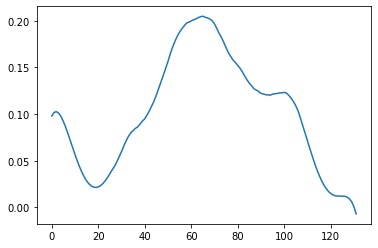

In [345]:
A_ = np.zeros(1000)
A_[:100] = A_hat
A_[A_==0] = A_hat*0.9
data = prestige_dirichlet(A_,binary=True,J=1,k=100,l=10)
plot_model(data)

## GT model

### Binary model

In [346]:
def binary_GT_model(A_,m=1000,b=b,J=J,alpha=alpha,A_hat=A_hat,conv_tol=0):
    np.random.seed()
    
    p = np.empty(m)
    p[:] = np.nan
    
    i = 0
    while True:
        if not np.isnan(p[-1]):
            addition = np.empty(m)
            addition[:] = np.nan
            p = np.array(list(p)+ list(addition))
        
        p[i]=len(A_[A_==A_hat])/len(A_)
        
        A_converge = (np.abs(A_-A_[0]) <= conv_tol).all()
        if A_converge:
            break
            
        new_A = []
        copiers = np.random.rand(len(A_))
        K = np.zeros(len(A_))
        for j in range(len(A_)):
            if isinstance(J,(list,np.ndarray)):
                biased_A = bias(A_,b,J[j])*alpha
            else:
                biased_A = bias(A_,b,J)*alpha
                
            prestige = biased_A + (1-alpha)*K
            prestige /= prestige.sum()
            chosen_role_model = np.searchsorted(prestige.cumsum(),copiers[j])
            K[chosen_role_model] += 1
            new_A.append(A_[chosen_role_model])
        A_ = np.array(new_A)
        i+=1
        
    return p

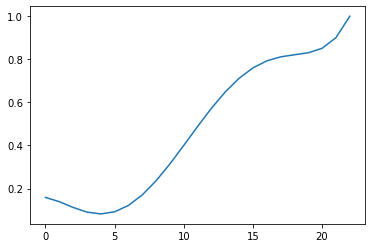

In [354]:
A_ = np.zeros(100)
A_[:20] = A_hat
A_[A_==0] = A_hat - 1e-8
data = binary_GT_model(A_,J=1)
plot_model(data)

### Continous model

# Parallel computing

In [355]:
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import as_completed
from functools import partial


def compute_model_parallel(A_,model,reps=100,max_workers=None):
    futures = []
    with ProcessPoolExecutor(max_workers) as executor:
        for _ in range(int(reps)):
            f = executor.submit(model,A_.copy())
            futures.append(f)

    results = []
    for data in as_completed(futures): 
        results.append(data.result())
    
    return results 

def gt_binary_model_parallel(A_,reps=100,b=b,J=J,alpha=alpha,max_workers=10):
    fixed_model = partial(binary_GT_model,b=b,J=J,alpha=alpha,A_hat=A_hat)
    return compute_model_parallel(A_,fixed_model,reps,max_workers=max_workers)
    
def dirichlet_model_parallel(A_,reps=100,binary=True,mutation_scale=0,conv_tol=0,b=b,J=J,alpha=alpha
                             ,k=None,l=None,max_workers=10):
    fixed_model = partial(prestige_dirichlet,binary=binary,mutation_scale=mutation_scale,
                          conv_tol=conv_tol,b=b,J=J,alpha=alpha,k=k,l=l)
    return compute_model_parallel(A_,fixed_model,reps,max_workers=max_workers) 

## Continous model results aggregation

### Test Dirichlet model

# Binary model

In [356]:
def aggregate_binary_model_with_errors(res,A_hat,sample_size):
    fixation_count = 0
    fixation_gens = []
    mean_growth_rate = 0
    diffs = []
    for arr in res:
        arr = arr[~np.isnan(arr)]
        if arr[-1]==1:
            fixation_count += 1
            fixation_gens.append(len(arr))
            
            diff = np.diff(arr).mean()
            diffs.append(diff)
        
    fixation_gens = np.array(fixation_gens)
    fixation_prob = fixation_count/len(res)
    if fixation_prob == 0:
        fixation_prob_err = 0
        fixation_gen_mean = 0
        fixation_gen_err = 0
        mean_growth_rate = 0
    else:    
        fixation_prob_err = probability_err(fixation_prob,sample_size)
        fixation_gen_mean = fixation_gens.mean()
        fixation_conf = st.t.interval(0.95, len(fixation_gens)-1, loc=fixation_gen_mean, scale=st.sem(fixation_gens))
        fixation_gen_err = (fixation_conf[1] - fixation_conf[0])/2
        mean_growth_rate = np.array(diffs).mean()
    
    return fixation_prob,fixation_prob_err,fixation_gen_mean,fixation_gen_err,mean_growth_rate

## Kimura's equations

In [357]:
def kimura(p0,s,N):
    numer = 1 - np.exp(-2*s*N*p0)
    denom = 1 - np.exp(-2*s*N)
    return numer/denom


def effective_population(N,alpha):
    return alpha*N + (1-alpha)
    

def durret(x,alpha,beta,N):
    Ne = effective_population(N,alpha)
    numer = 1 - np.exp(-2*(1-beta)*Ne*x)
    denom = 1 - np.exp(-2*(1-beta)*Ne)
    return numer/denom


def durret_change_env(x,alpha,s_n,N):
    Ne = effective_population(N,alpha)
    numer = 1 - np.exp(-2*s_n*Ne*x)
    denom = 1 - np.exp(-2*s_n*Ne)
    return numer/denom

In [358]:
def integral(f, N, s, a, b):
    f = partial(f, N, s)    
    return quad(f, a, b)[0]


def I1(N, s, x):
    if x == 1:
        return 0
    return (1 - np.exp(-2*N*s*x) - np.exp(-2 * N * s * (1 - x)) + np.exp(-2 * N *s)) / (x*(1-x))


def I2(N, s, x):
    if x == 0:
        return 0
    return -np.expm1(2 * N * s * x) * np.expm1(-2 * N * s * x) / (x * (1 - x))


@np.vectorize
def T_kimura(n0, N, s):
    x = n0 / N
    J1 = -1.0 / (s * np.expm1(-2 * N * s)) * integral(I1, N, s, x, 1)
    u = np.expm1(-2 * N * s * x) / np.expm1(-2 * N * s)
    J2 = -1.0 / (s * np.expm1(-2 * N *s)) * integral(I2, N, s, 0, x)
    return J1 + ((1 - u) / u) * J2

## Test models

### Test Dirichlet model

In [359]:
N = 1000
p0 = 1e-3
A = A_hat*0.7
alpha = 0.4
J=1
A_ = np.zeros(N)
A_[:int(p0*N)] = A_hat
A_[A_==0] = A
beta = bias(A,J=J,A_hat=A_hat)
results = dirichlet_model_parallel(A_,reps=10000,binary=True,J=J,alpha=alpha,max_workers=30)

aggregated_results = aggregate_binary_model_with_errors(results,A_hat,len(results))
fixation_prob,fixation_prob_err,fixation_gen_mean,fixation_gen_err,growth_rate = aggregated_results

print(f'fixation probability and estimated error: {fixation_prob} \t {fixation_prob_err}')
print(f'durret probability: {durret(p0,alpha,beta,N):.4f}')
print(f'fixation growth rate and mean fixation time:{growth_rate:.4f} \t {fixation_gen_mean}')
print(f'beta:{beta:.4f}')

fixation probability and estimated error: 0.0346 	 0.007164365991321214
durret probability: 0.0346
fixation growth rate and mean fixation time:0.0058 	 181.63294797687863
beta:0.9560


### Test Wright-Fisher fixation probability

In [360]:
def wf_fix_prob(n0, N, s, repetitions=10):
    N = int(N)
    n = np.repeat(n0, repetitions)
    n[:] = n0 # broadcasting
    update = (n > 0) & (n < N)
    while update.any():
        p = n * (1 + s) / (N + n * s)
        n[update] = np.random.binomial(N, p[update])
        update = (n > 0) & (n < N)
    return (n == N).mean()


N = 10000
s = 1e-3
p0 = 1e-4
reps = 10000
n0 = p0*N

p = wf_fix_prob(n0, N, s, reps)
print(f'fixation probability and probability error: {p}\t{probability_err(p,N):.4f}')
print(f'kimura probability: {kimura(p0,s,N):.4f}')

fixation probability and probability error: 0.0019	0.0017
kimura probability: 0.0020


### Test Wright-Fisher fixation time

In [361]:
def wf_fix_time_with_err(results):
    is_fixed,times = results
    fixation_gens = times[is_fixed]
    fixation_gen_mean = fixation_gens.mean()
    fixation_conf = st.t.interval(0.95, len(fixation_gens)-1, loc=fixation_gen_mean, scale=st.sem(fixation_gens))
    fixation_gen_err = (fixation_conf[1] - fixation_conf[0])/2
    
    return fixation_gen_mean,fixation_gen_err
    


def wf_fix_time_sim(n0, N, s, repetitions=10):
    N = int(N)
    n = np.repeat(n0, repetitions)
    T = np.repeat(np.inf, repetitions)
    
    t = 0
    n[:] = n0
    update = (n > 0) & (n < N)
    while update.any():        
        p = n * (1 + s) / (N + n * s)
        n[update] = np.random.binomial(N, p[update])
        update = (n > 0) & (n < N)
        t += 1
        T[~update] = np.minimum(T[~update], t)
    return n == N, T


N = effective_population(1000,0.2)
s = 1-0.956
p0 = 1e-4
reps = 10000
n0 = p0*N
t,t_err = wf_fix_time_with_err(wf_fix_time_sim(n0, N, s, reps))
print(f'fixation time and error: {t:.2f}\t\t\t{t_err:.4f}')
print(f'kimura fixation time: {T_kimura(n0, N, s):.4f}')

fixation time and error: 157.76			27.2505
kimura fixation time: 154.0194


## Compare DM vs WF

### Variating $\alpha$

In [23]:
alphas = np.linspace(start=1e-4,stop=0.999,num=30)
N = 1000
p0 = 1e-3
A = A_hat*0.7
A_ = np.zeros(N)
A_[:int(p0*N)] = A_hat
A_[A_==0] = A
beta = bias(A,J=J,A_hat=A_hat)

sim_res_alpha = []
for alpha in alphas:
    results = dirichlet_model_parallel(A_,binary=True,reps=10000,J=J,alpha=alpha,max_workers=60)

    aggregated_results = aggregate_binary_model_with_errors(results,A_hat,len(results))
    fixation_prob,fixation_prob_err,fix_time,fix_time_err,_ = aggregated_results
    
    durr = durret(p0,alpha,beta,N)
    
    sim_res_alpha.append((fixation_prob,fixation_prob_err,durr,fix_time,fix_time_err))

In [24]:
wf_res_alpha = []
s = 1-beta
for alpha in alphas:
    Ne = effective_population(N,alpha)
    n0 = p0*Ne
    p = wf_fix_prob(n0, Ne, s, reps)
    p_err = probability_err(p,reps)
    t,t_err = wf_fix_time_with_err(wf_fix_time_sim(n0, Ne, s, reps))
    kim = T_kimura(n0, Ne, s)
    wf_res_alpha.append((p,p_err,t,t_err,kim,Ne))

/home/medaware/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/medaware/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


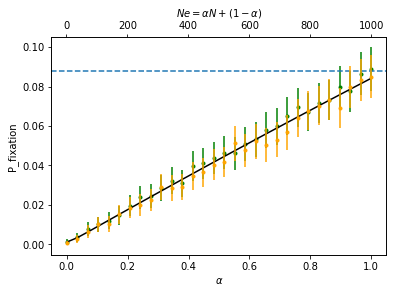

In [26]:
Y = [tup[0] for tup in sim_res_alpha]
Y_err = [tup[1] for tup in sim_res_alpha]
durrs = [tup[2] for tup in sim_res_alpha]

Y_wf = [tup[0] for tup in wf_res_alpha]
Y_wf_err = [tup[1] for tup in wf_res_alpha]
Nes = [tup[-1] for tup in wf_res_alpha]

ax1 = plt.gca()
ax2 = ax1.twiny()

ax1.set_xlabel(r'$\alpha$')
ax2.set_xlabel(r'$Ne=\alpha N + (1-\alpha)$')
ax1.set_ylabel(r'P_fixation')
l1 = ax1.axhline(2*(1-beta), ls='--', label=r'$2(1-\beta) = 2s$')
l2 = ax1.plot(alphas,durrs,label= 'kimura',zorder=2,color='k')
l3 = ax1.errorbar(alphas,Y,yerr=Y_err,fmt='o',color='green',markersize=3,zorder=1)
l4 = ax2.errorbar(Nes,Y_wf,yerr=Y_wf_err,fmt='o',color='orange',zorder=0,markersize=3);

lns = (l1,l2[0],l3[0],l4[0])
labs = [l1.get_label(),l2[0].get_label(),'DM simulations','WF simulations']
plt.savefig('../figures/fix_prob_var_alpha.pdf')

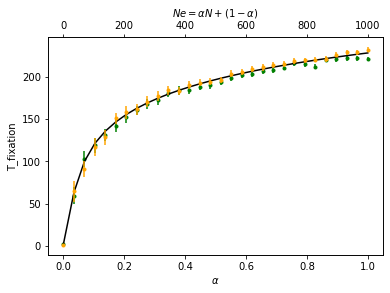

In [27]:
Y = [tup[3] for tup in sim_res_alpha]
Y_err = [tup[4] for tup in sim_res_alpha]

Y_wf = [tup[2] for tup in wf_res_alpha]
Y_wf_err = [tup[3] for tup in wf_res_alpha]
kims = [tup[4] for tup in wf_res_alpha]

ax1 = plt.gca()
ax2 = ax1.twiny()

ax1.set_xlabel(r'$\alpha$')
ax2.set_xlabel(r'$Ne=\alpha N + (1-\alpha)$')
ax1.set_ylabel(r'T_fixation')
l1 = ax1.plot(alphas,kims,label= 'kimura',zorder=2,color='k')
l2 = ax1.errorbar(alphas,Y,yerr=Y_err,fmt='o',color='green',markersize=3,zorder=1)
l3 = ax2.errorbar(Nes,Y_wf,yerr=Y_wf_err,fmt='o',color='orange',zorder=0,markersize=3);

lns = (l1[0],l2[0],l3[0])
labs = [l1[0].get_label(),'DM simulations','WF simulations']
plt.savefig('../figures/fix_time_var_alpha.pdf')

### Varying $\beta$

In [28]:
trait_modifiers = np.linspace(start=0.01,stop=0.99,num=30)
N = 1000
alpha = 0.01
p0 = 1e-3
sim_res_beta = []
for mod in trait_modifiers:
    A = A_hat*mod
    beta = bias(A,J=J,A_hat=A_hat)
    
    A_ = np.zeros(N)
    A_[:int(p0*N)] = A_hat
    A_[A_==0] = A
    results = dirichlet_model_parallel(A_,binary=True,reps=10000,J=J,alpha=alpha,max_workers=60)

    aggregated_results = aggregate_binary_model_with_errors(results,A_hat,len(results))
    fixation_prob,fixation_prob_err,fix_time,fix_time_err,_ = aggregated_results
    
    durr = durret(p0,alpha,beta,N)
    
    sim_res_beta.append((fixation_prob,fixation_prob_err,durr,fix_time,fix_time_err,beta))

In [29]:
neg_betas = 1 - np.array([tup[-1] for tup in sim_res_beta])
Ne = effective_population(N,alpha)
wf_res_s = []

for s in neg_betas:
    n0 = p0*Ne
    p = wf_fix_prob(n0, Ne, s, reps)
    p_err = probability_err(p,reps)
    t,t_err = wf_fix_time_with_err(wf_fix_time_sim(n0, Ne, s, reps))
    kim = T_kimura(n0, Ne, s)
    wf_res_s.append((p,p_err,t,t_err,kim))

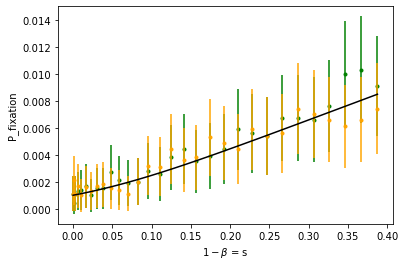

In [30]:
Y = [tup[0] for tup in sim_res_beta]
Y_err = [tup[1] for tup in sim_res_beta]
durrs = [tup[2] for tup in sim_res_beta]

Y_wf = [tup[0] for tup in wf_res_s]
Y_wf_err = [tup[1] for tup in wf_res_s]


plt.xlabel(r'$1-\beta$ = s')
plt.ylabel(r'P_fixation')
plt.plot(neg_betas,durrs,zorder=2,label='kimura',color='k')
plt.errorbar(neg_betas,Y,yerr=Y_err,fmt='o',label='DM simulations',zorder=0,markersize=3,color='g');
plt.errorbar(neg_betas,Y_wf,yerr=Y_wf_err,fmt='o',label='WF simulations',zorder=1,markersize=3,color='orange');

plt.savefig('../figures/fix_prob_var_beta.pdf')

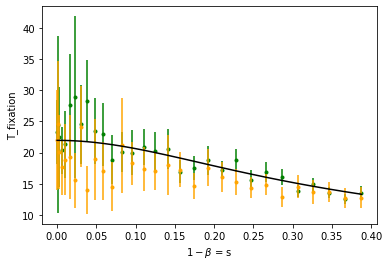

In [31]:
Y = [tup[3] for tup in sim_res_beta]
Y_err = [tup[4] for tup in sim_res_beta]

Y_wf = [tup[2] for tup in wf_res_s]
Y_wf_err = [tup[3] for tup in wf_res_s]
kims = [tup[4] for tup in wf_res_s]


plt.xlabel(r'$1-\beta$ = s')
plt.ylabel(r'T_fixation')
plt.plot(neg_betas,kims,zorder=2,label='kimura',color='k')
plt.errorbar(neg_betas,Y,yerr=Y_err,fmt='o',label='DM simulations',zorder=0,markersize=3,color='g');
plt.errorbar(neg_betas,Y_wf,yerr=Y_wf_err,fmt='o',label='WF simulations',zorder=1,markersize=3,color='orange');

plt.savefig('../figures/fix_time_var_beta.pdf')

## Compare DM vs full model

In [349]:
def plot_binary_comparison(x_axis,full_res,dm_res,x_name,log_scale=False,kims=None):
    fig, axs = plt.subplot_mosaic(['a)','b)'],figsize=[10,5])
    listify = lambda x,i: [y[i] for y in x]
    
    axs[0].set_ylabel('Fixation probability')
    axs[0].set_xlabel(x_name)
    l1 = axs[0].errorbar(x_axis,listify(full_res,0),yerr=listify(full_res,1),fmt='-o',alpha=0.5)
    l2 = axs[0].errorbar(x_axis,listify(dm_res,0),yerr=listify(dm_res,1),fmt='-*')
    l3 = axs[0].axhline(kims[0], color='k')

    axs[1].set_ylabel('Fixation time')
    axs[1].set_xlabel(x_name)
    axs[1].errorbar(x_axis,listify(full_res,2),yerr=listify(full_res,3),fmt='-o',alpha=0.5)
    axs[1].errorbar(x_axis,listify(dm_res,2),yerr=listify(dm_res,3),fmt='-*')
    axs[1].axhline(kims[1],color='k')
    for ax in axs.flat:
        if log_scale:
            ax.set_xscale('log')

    fig.tight_layout()

### Number of simulations

In [ ]:
num_reps = np.linspace(100,5000,30)
N=1000
alpha=0.5
A_ = np.zeros(N)
J=1
A_[0] = A_hat
A_[A_==0] = A_hat*0.7
beta = bias(A_hat*0.7,J=J)
Ne = effective_population(N,alpha)
kims = (durret(1e-3,alpha,beta,N),T_kimura(1, Ne, 1-beta))
gt_results = []
dm_results = []

for reps in num_reps:
    full_results = gt_binary_model_parallel(A_,reps=reps,J=J,alpha=alpha,max_workers=10)
    aggregated_results = aggregate_binary_model_with_errors(full_results,A_hat,len(results))
    gt_results.append(aggregated_results)

    results = dirichlet_model_parallel(A_,binary=True,reps=reps,J=J,alpha=alpha,max_workers=10)
    aggregated_results = aggregate_binary_model_with_errors(results,A_hat,len(results))
    dm_results.append(aggregated_results)

In [ ]:
plot_binary_comparison(num_reps,gt_results,dm_results,x_name='Number of simulations',kims=kims)
plt.savefig('../figures/num_sims.pdf')

### Mutation

In [362]:
N=1000
alpha=0.1
A_ = np.zeros(N)
A_[0] = A_hat
A_[A_==0] = A_hat*0.7
mutations = np.logspace(-7,-1,30)
reps = 1000
orig_J = 1
gt_results = []
dm_results = []
Ne = effective_population(N,alpha)
beta = bias(A_hat*0.7,J=orig_J)
kims = (durret(1e-3,alpha,beta,N),T_kimura(1, Ne, 1-beta))
for mutation in mutations:
    J = np.random.normal(orig_J, scale = mutation, size=len(A_))
    
    full_results = gt_binary_model_parallel(A_,reps=reps,J=J,alpha=alpha,max_workers=60)
    aggregated_results = aggregate_binary_model_with_errors(full_results,A_hat,len(results))
    gt_results.append(aggregated_results)

    results = dirichlet_model_parallel(A_,binary=True,reps=reps,J=orig_J,alpha=alpha,max_workers=60)
    aggregated_results = aggregate_binary_model_with_errors(results,A_hat,len(results))
    dm_results.append(aggregated_results)

In [363]:
plot_binary_comparison(mutations,gt_results,dm_results,x_name='estimation error variance',log_scale=True,kims=kims)
plt.savefig('../figures/full_vs_dm_mutation.pdf')

ValueError: List layout specification must be 2D

<Figure size 720x360 with 0 Axes>

### Heterogenous $\alpha$

In [37]:
N=1000
alpha=0.5
A_ = np.zeros(N)
J=1
A_[0] = A_hat
A_[A_==0] = A_hat*0.7
scales = np.logspace(-7,-1,30)
reps = 5000
Ne = effective_population(N,alpha)
beta = bias(A_hat*0.7,J=J)
kims = (durret(1e-3,alpha,beta,N),T_kimura(1, Ne, 1-beta))
gt_results = []
dm_results = []
for scale in scales:
    normal_alpha = np.random.normal(alpha, scale = scale, size=len(A_))
    
    full_results = gt_binary_model_parallel(A_,reps=reps,J=J,alpha=alpha,max_workers=60)
    aggregated_results = aggregate_binary_model_with_errors(full_results,A_hat,len(results))
    gt_results.append(aggregated_results)

    results = dirichlet_model_parallel(A_,binary=True,reps=reps,J=J,alpha=alpha,max_workers=60)
    aggregated_results = aggregate_binary_model_with_errors(results,A_hat,len(results))
    dm_results.append(aggregated_results)

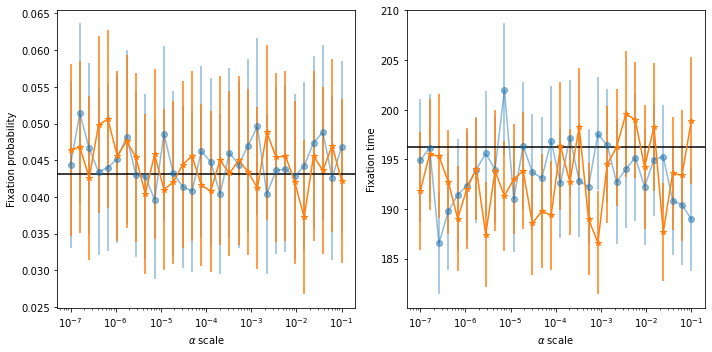

In [38]:
plot_binary_comparison(scales,gt_results,dm_results,x_name=r'$\alpha$ scale',log_scale=True,kims=kims)
plt.savefig('../figures/full_vs_dm_changing_alpha.pdf')

## Changing environment

In [39]:
N = 1000
p0 = 1/N
A = A_hat*0.9
alpha = 0.1
J=1
A_ = np.zeros(N)
A_[0] = A_hat
A_[1:] = A
beta = bias(A, J=J, A_hat=A_hat)
k,l=20,80
s_n = ((k-l)/(k+l))*(1-beta)
Ne = effective_population(N, alpha)

print(fr's_n:{s_n:.4f}')
print(f'beta:{beta:.4f}')
print(f'Ne:{Ne}')
print(f'envch fix prob: {durret_change_env(p0,alpha,s_n,N):.4g}')
print(f'const fix prob: {durret(p0,alpha,beta,N):.4g}')
print(f'envch fix time: {T_kimura(p0*N,Ne,s_n):.4g}')
print(f'const fix time: {T_kimura(p0*N,Ne,1-beta):.4g}')

results = dirichlet_model_parallel(A_,reps=10000,binary=True,J=J,alpha=alpha,max_workers=30,k=k,l=l)

aggregated_results = aggregate_binary_model_with_errors(results,A_hat,len(results))
fixation_prob,fixation_prob_err,fixation_gen_mean,fixation_gen_err,growth_rate = aggregated_results

print(f'fixation probability and estimated error: {fixation_prob:.4g} \t {fixation_prob_err:.4g}')
print(f'fixation time and estimated error:{fixation_gen_mean:.4g} \t {fixation_gen_err:.4g}')


s_n:-0.0030
beta:0.9950
Ne:100.9
envch fix prob: 0.0007285
const fix prob: 0.001585
envch fix time: 199.8
const fix time: 198
fixation probability and estimated error: 0.0005 	 0.0008763
fixation time and estimated error:168.8 	 144.4


### Variating $\alpha$

In [40]:
alphas = np.linspace(start=1e-4,stop=0.999,num=30)


N = 1000
p0 = 1/N
A = A_hat*0.9
J=1
A_ = np.zeros(N)
A_[0] = A_hat
A_[1:] = A
beta = bias(A, J=J, A_hat=A_hat)
k,l=30,80
s_n = ((k-l)/(k+l))*(1-beta)

sim_res_alpha = []
for alpha in alphas:
    ch_res = durret_change_env(p0,alpha,s_n,N)
    const_res = durret(p0,alpha,beta,N)
    results = dirichlet_model_parallel(A_,reps=10000,binary=True,J=J,alpha=alpha,max_workers=30,k=k,l=l)

    aggregated_results = aggregate_binary_model_with_errors(results,A_hat,len(results))
    fixation_prob,prob_err,*_ = aggregated_results
    
    sim_res_alpha.append((ch_res,fixation_prob,prob_err,const_res))
    
sim_res_alpha = np.array(sim_res_alpha)
Ne = effective_population(N, alphas)

/home/medaware/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/medaware/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


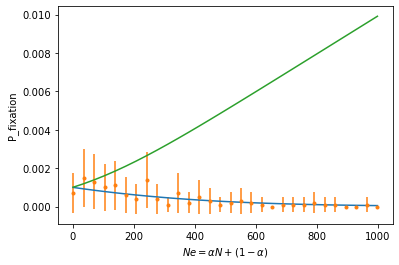

In [41]:
plt.plot(Ne,sim_res_alpha[:,0],label='changing env')
plt.errorbar(Ne,sim_res_alpha[:,1],yerr=sim_res_alpha[:,2],fmt='o',markersize=3,label='simulations')
plt.plot(Ne,sim_res_alpha[:,3],label='constant env')
plt.xlabel(r'$Ne=\alpha N + (1-\alpha)$')
plt.ylabel(r'P_fixation')
plt.savefig('../figures/ch_env_var_alpha.pdf');

### Variating $\beta$

In [42]:
trait_modifiers = np.linspace(start=0.01,stop=0.99,num=30)


N = 1000
p0 = 1/N
J=1
A_ = np.zeros(N)
alpha = 0.1
k,l=30,80

sim_res_beta = []
for mod in trait_modifiers:
    A = A_hat*mod
    A_[0] = A_hat
    A_[1:] = A
    beta = bias(A,J=J,A_hat=A_hat)
    s_n = ((k-l)/(k+l))*(1-beta)
    
    ch_res = durret_change_env(p0,alpha,s_n,N)
    const_res = durret(p0,alpha,beta,N)
    results = dirichlet_model_parallel(A_,reps=10000,binary=True,J=J,alpha=alpha,max_workers=30,k=k,l=l)

    aggregated_results = aggregate_binary_model_with_errors(results,A_hat,len(results))
    fixation_prob,prob_err,*_ = aggregated_results
    
    sim_res_beta.append((ch_res,fixation_prob,prob_err,const_res,1-beta))
    
sim_res_beta = np.array(sim_res_beta)

/home/medaware/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/medaware/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


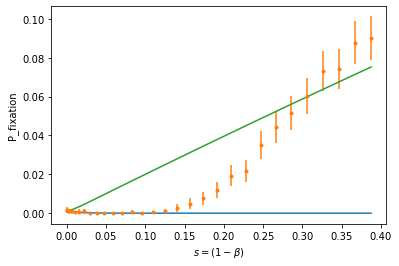

In [43]:
plt.plot(sim_res_beta[:,-1],sim_res_beta[:,0],label='changing env')
plt.errorbar(sim_res_beta[:,-1],sim_res_beta[:,1],yerr=sim_res_beta[:,2],fmt='o',markersize=3,label='simulations')
plt.plot(sim_res_beta[:,-1],sim_res_beta[:,3],label='constant env')
plt.xlabel(r'$s=(1-\beta)$')
plt.ylabel(r'P_fixation')
plt.savefig('../figures/ch_env_var_beta.pdf');

### Variating $k,l$

In [44]:
n=40
ks = np.arange(1,n,2)

N = 1000
p0 = 1/N
A = A_hat*0.8
J=1
A_ = np.zeros(N)
A_[0] = A_hat
A_[1:] = A
beta = bias(A, J=J, A_hat=A_hat)
alpha=0.1


sim_res_k_l = []
for k in ks:
    l = n-k
    if k==l:
        continue
    
    s_n = ((k-l)/n)*(1-beta)
    
    ch_res = durret_change_env(p0,alpha,s_n,N)
    const_res = durret(p0,alpha,beta,N)
    results = dirichlet_model_parallel(A_,reps=10000,binary=True,J=J,alpha=alpha,max_workers=30,k=k,l=l)

    aggregated_results = aggregate_binary_model_with_errors(results,A_hat,len(results))
    fixation_prob,prob_err,*_ = aggregated_results
    
    sim_res_k_l.append((ch_res,fixation_prob,prob_err,const_res,k-l))
    
sim_res_k_l = np.array(sim_res_k_l)

/home/medaware/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/medaware/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


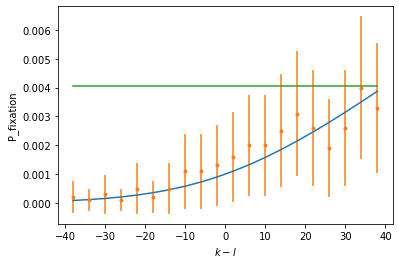

In [45]:
plt.plot(sim_res_k_l[:,-1],sim_res_k_l[:,0],label='changing env')
plt.errorbar(sim_res_k_l[:,-1],sim_res_k_l[:,1],yerr=sim_res_k_l[:,2],fmt='o',markersize=3,label='simulations')
plt.plot(sim_res_k_l[:,-1],sim_res_k_l[:,3],label='constant env')
plt.xlabel(r'$k-l$')
plt.ylabel(r'P_fixation')
plt.savefig('../figures/ch_env_var_k_min_l.pdf');

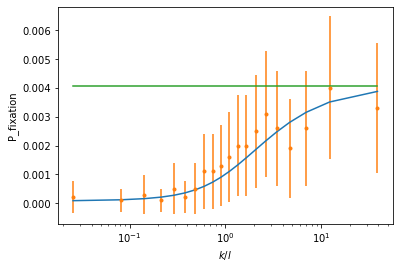

In [46]:
ls = n-ks
x = ks/ls
x = x[x!=1]
plt.plot(x,sim_res_k_l[:,0],label='changing env')
plt.errorbar(x,sim_res_k_l[:,1],yerr=sim_res_k_l[:,2],fmt='o',markersize=3,label='simulations')
plt.plot(x,sim_res_k_l[:,3],label='constant env')
plt.xscale('log')
plt.xlabel(r'$k/l$')
plt.ylabel(r'P_fixation')
plt.savefig('../figures/ch_env_var_k_div_l.pdf');